# Nonscalar Example (LQ Game)

## Parameter Initialization:

In [1]:
using Ipopt, JuMP, LinearAlgebra, PyPlot, Statistics

Kf = 100

Q₁ = I(2)
Q₂ = I(2)
Q₃ = I(2)
Q₄ = I(2)

R₁ = 1
R₂ = 1
R₃ = 1
R₄ = 1

R₁₂ = 1
R₁₄ = 1
R₂₃ = 1
R₃₁ = 1

A = [0.995 0.09983; -0.09983 0.995] 
B₁ = [0.2047; 0.08984]
B₂ = [0.2147; 0.2895]
B₃ = [0.2097; 0.1897]
B₄ = [0.2; 0.1]

C = [B₁'*Q₁ ; B₂'*Q₂; B₃'*Q₃; B₄'*Q₄]

Mbr = [(B₁'*Q₁*B₁ + R₁) B₁'*Q₁*B₂ B₁'*Q₁*B₃ B₁'*Q₁*B₄;
       B₂'*Q₂*B₁ (B₂'*Q₂*B₂ + R₂) B₂'*Q₂*B₃ B₂'*Q₂*B₄;
       B₃'*Q₃*B₁ B₃'*Q₃*B₂ (B₃'*Q₃*B₃ + R₃) B₃'*Q₃*B₄;
       B₄'*Q₄*B₁ B₄'*Q₄*B₂ B₄'*Q₄*B₃ (B₄'*Q₄*B₄ + R₄)]

Mj = [(B₁'*Q₁*B₁ + R₁) 0 0 0;
      0 (B₂'*Q₂*B₂ + R₂) 0 0;
      0 0 (B₃'*Q₃*B₃ + R₃) 0;
      0 0 0 (B₄'*Q₄*B₄ + R₄)]

Mgs = [(B₁'*Q₁*B₁ + R₁) 0 0 0;
       B₂'*Q₂*B₁ (B₂'*Q₂*B₂ + R₂) 0 0;
       B₃'*Q₃*B₁ B₃'*Q₃*B₂ (B₃'*Q₃*B₃ + R₃) 0;
       B₄'*Q₄*B₁ B₄'*Q₄*B₂ B₄'*Q₄*B₃ (B₄'*Q₄*B₄ + R₄)]

Nj = [0 B₁'*Q₁*B₂ B₁'*Q₁*B₃ B₁'*Q₁*B₄;
      B₂'*Q₂*B₁ 0 B₂'*Q₂*B₃ B₂'*Q₂*B₄;
      B₃'*Q₃*B₁ B₃'*Q₃*B₂ 0 B₃'*Q₃*B₄;
      B₄'*Q₄*B₁ B₄'*Q₄*B₂ B₄'*Q₄*B₃ 0]

Ngs = [0 B₁'*Q₁*B₂ B₁'*Q₁*B₃ B₁'*Q₁*B₄;
       0 0 B₂'*Q₂*B₃ B₂'*Q₂*B₄;
       0 0 0 B₃'*Q₃*B₄;
       0 0 0 0]

Lbr = - inv(Mbr)*C

Kbr = Lbr*A

Lj = - inv(Mj)*C

Kj = Lj*A

Lgs = - inv(Mgs)*C

Kgs = Lgs*A

x_init = [0.4; 0.3] 
x_ref = zeros(2);

## Convergence Condition:

In [2]:
A_br = A + B₁*Kbr[1,:]' + B₂*Kbr[2,:]' + B₃*Kbr[3,:]' + B₄*Kbr[4,:]'

A_jac = A + B₁*Kj[1,:]' + B₂*Kj[2,:]' + B₃*Kj[3,:]' + B₄*Kj[4,:]'

A_gs = A + B₁*Kgs[1,:]' + B₂*Kgs[2,:]' + B₃*Kgs[3,:]' + B₄*Kgs[4,:]'

# Convergence Condition: Best Response
SR_br = maximum(abs.(eigvals(A_br)))

if SR_br <= 1
    br_check = true
else
    br_check = false
end

# Convergence Condition: Jacobi
SR_jac = maximum(abs.(eigvals(A_jac)))

if SR_jac <= 1
    jac_check = true
else
    jac_check = false
end

# Convergence Condition: Gauss-Seidel
SR_gs = maximum(abs.(eigvals(A_gs))) 

if SR_gs <= 1
    gs_check = true
else
    gs_check = false
end

println("Best Response:")
println("Convergence check is ", br_check)
println("ρ(Abr) = ", round(SR_br, digits=6), "\n")

println("Jacobi Game:")
println("Convergence check is ", jac_check)
println("ρ(Aj) = ", round(SR_jac, digits=6), "\n")

println("Gauss-Seidel Game:")
println("Convergence check is ", gs_check)
println("ρ(Ags) = ", round(SR_gs, digits=6), "\n")

Best Response:
Convergence check is true
ρ(Abr) = 0.936883

Jacobi Game:
Convergence check is true
ρ(Aj) = 0.950842

Gauss-Seidel Game:
Convergence check is true
ρ(Ags) = 0.943394



## Best Response Simulation:

In [3]:
x_br = zeros(2, Kf+1)
x_br[:,1] = x_init

u_br = zeros(4,Kf)

J1_br = x_br[:,1]'*Q₁*x_br[:,1] 
J2_br = x_br[:,1]'*Q₂*x_br[:,1]
J3_br = x_br[:,1]'*Q₃*x_br[:,1]
J4_br = x_br[:,1]'*Q₄*x_br[:,1] 

for k in 1:Kf
    u_br[:,k] = Kbr*x_br[:,k] - Lbr*x_ref
    
    #Simulated Dynamics
    x_br[:,k+1] = A*x_br[:,k] + B₁*u_br[1,k] + B₂*u_br[2,k] + B₃*u_br[3,k] + B₄*u_br[4,k]

    #Accumulated Objective For Player 1
    J1_br += x_br[:,k+1]'*Q₁*x_br[:,k+1] + R₁*u_br[1,k]^2 + R₁₂*u_br[2,k]^2 + R₁₄*u_br[4,k]^2
    
    #Accumulated Objective For Player 2
    J2_br += x_br[:,k+1]'*Q₂*x_br[:,k+1] + R₂*u_br[2,k]^2 + R₂₃*u_br[3,k]^2

    #Accumulated Objective For Player 3
    J3_br += x_br[:,k+1]'*Q₃*x_br[:,k+1] + R₃₁*u_br[1,k]^2 + R₃*u_br[3,k]^2

    #Accumulated Objective For Player 4
    J4_br += x_br[:,k+1]'*Q₄*x_br[:,k+1] + R₄*u_br[4,k]^2
end

println("Evolution of the state x₁ = ", round.(x_br[1,:], digits=4), "\n")
println("Evolution of the state x₂ = ", round.(x_br[2,:], digits=4), "\n")
println("Evolution of the control input of Player 1, u₁ = ", round.(u_br[1,:], digits=4), "\n")
println("Evolution of the control input of Player 2, u₂ = ", round.(u_br[2,:], digits=4), "\n")
println("Evolution of the control input of Player 3, u₃ = ", round.(u_br[3,:], digits=4), "\n")
println("Evolution of the control input of Player 4, u₄ = ", round.(u_br[4,:], digits=4), "\n")
println("Accumulated Objective (Player 1), J₁(Kf) = ", round(J1_br, digits=4), "\n")
println("Accumulated Objective (Player 2), J₂(Kf) = ", round(J2_br, digits=4), "\n") 
println("Accumulated Objective (Player 3), J₃(Kf) = ", round(J3_br, digits=4), "\n") 
println("Accumulated Objective (Player 4), J₄(Kf) = ", round(J4_br, digits=4)) 

Evolution of the state x₁ = [0.4, 0.343, 0.2956, 0.256, 0.2228, 0.1949, 0.1714, 0.1514, 0.1345, 0.1199, 0.1075, 0.0967, 0.0874, 0.0793, 0.0721, 0.0658, 0.0603, 0.0553, 0.0509, 0.0469, 0.0434, 0.0401, 0.0372, 0.0345, 0.0321, 0.0298, 0.0278, 0.0259, 0.0241, 0.0225, 0.021, 0.0196, 0.0183, 0.0171, 0.016, 0.015, 0.014, 0.0131, 0.0123, 0.0115, 0.0107, 0.0101, 0.0094, 0.0088, 0.0083, 0.0077, 0.0072, 0.0068, 0.0064, 0.006, 0.0056, 0.0052, 0.0049, 0.0046, 0.0043, 0.004, 0.0038, 0.0035, 0.0033, 0.0031, 0.0029, 0.0027, 0.0025, 0.0024, 0.0022, 0.0021, 0.002, 0.0018, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0012, 0.0011, 0.001, 0.001, 0.0009, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002]

Evolution of the state x₂ = [0.3, 0.1849, 0.0952, 0.0257, -0.0274, -0.0676, -0.0973, -0.1188, -0.1338, -0.1436, -0.1493, -0.1519, -0.1521, -0.1505, -0.1474, -0.1433, -0.1386, -

## Nortmann et al. (Optimal Gains) Simulation:

In [4]:
x_nort = zeros(2, Kf+1)
x_nort[:,1] = x_init

u_nort = zeros(4,Kf)

K_nort = [-0.6918 0.1601;
           0.0052 -0.6095;
          -0.3953 -0.1560;
          -0.4239 0.0442]

J1_nort = x_nort[:,1]'*Q₁*x_nort[:,1] 
J2_nort = x_nort[:,1]'*Q₂*x_nort[:,1]
J3_nort = x_nort[:,1]'*Q₃*x_nort[:,1]
J4_nort = x_nort[:,1]'*Q₄*x_nort[:,1] 

for k in 1:Kf
    u_nort[:,k] = K_nort*x_nort[:,k]
    
    #Simulated Dynamics
    x_nort[:,k+1] = A*x_nort[:,k] + B₁*u_nort[1,k] + B₂*u_nort[2,k] + B₃*u_nort[3,k] + B₄*u_nort[4,k]

    #Accumulated Objective For Player 1
    J1_nort += x_nort[:,k+1]'*Q₁*x_nort[:,k+1] + R₁*u_nort[1,k]^2 + R₁₂*u_nort[2,k]^2 + R₁₄*u_nort[4,k]^2
    
    #Accumulated Objective For Player 2
    J2_nort += x_nort[:,k+1]'*Q₂*x_nort[:,k+1] + R₂*u_nort[2,k]^2 + R₂₃*u_nort[3,k]^2

    #Accumulated Objective For Player 3
    J3_nort += x_nort[:,k+1]'*Q₃*x_nort[:,k+1] + R₃₁*u_nort[1,k]^2 + R₃*u_nort[3,k]^2

    #Accumulated Objective For Player 4
    J4_nort += x_nort[:,k+1]'*Q₄*x_nort[:,k+1] + R₄*u_nort[4,k]^2
end

println("Evolution of the state x₁ = ", round.(x_nort[1,:], digits=4), "\n")
println("Evolution of the state x₂ = ", round.(x_nort[2,:], digits=4), "\n")
println("Evolution of the control input of Player 1, u₁ = ", round.(u_nort[1,:], digits=4), "\n")
println("Evolution of the control input of Player 2, u₂ = ", round.(u_nort[2,:], digits=4), "\n")
println("Evolution of the control input of Player 3, u₃ = ", round.(u_nort[3,:], digits=4), "\n")
println("Evolution of the control input of Player 4, u₄ = ", round.(u_nort[4,:], digits=4), "\n")
println("Accumulated Objective (Player 1), J₁(Kf) = ", round(J1_nort, digits=4), "\n")
println("Accumulated Objective (Player 2), J₂(Kf) = ", round(J2_nort, digits=4), "\n")
println("Accumulated Objective (Player 3), J₃(Kf) = ", round(J3_nort, digits=4), "\n")
println("Accumulated Objective (Player 4), J₄(Kf) = ", round(J4_nort, digits=4)) 

Evolution of the state x₁ = [0.4, 0.2681, 0.1812, 0.1238, 0.0856, 0.06, 0.0427, 0.0309, 0.0228, 0.0171, 0.013, 0.0101, 0.0079, 0.0063, 0.0051, 0.0042, 0.0034, 0.0028, 0.0023, 0.002, 0.0016, 0.0014, 0.0012, 0.001, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0004, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Evolution of the state x₂ = [0.3, 0.1312, 0.0315, -0.0249, -0.0545, -0.0678, -0.0714, -0.0696, -0.0648, -0.0587, -0.0521, -0.0457, -0.0397, -0.0343, -0.0295, -0.0252, -0.0215, -0.0183, -0.0156, -0.0133, -0.0113, -0.0095, -0.0081, -0.0069, -0.0058, -0.0049, -0.0042, -0.0035, -0.003, -0.0025, -0.0021, -0.0018, -0.0015, -0.0013, -0.0011, -0.0009, -0.0

## Jacobi Simulation:

In [5]:
x_jac = zeros(2, Kf+1)
x_jac[:,1] = x_init

u_jac = zeros(4,Kf)

J1_jac = x_jac[:,1]'*Q₁*x_jac[:,1] 
J2_jac = x_jac[:,1]'*Q₂*x_jac[:,1]
J3_jac = x_jac[:,1]'*Q₃*x_jac[:,1]
J4_jac = x_jac[:,1]'*Q₄*x_jac[:,1] 

Ztrans = -inv(Mj)*Nj

u_old = zeros(4)

for k in 1:Kf
    u_jac[:,k] = Ztrans*u_old + Kj*x_jac[:,k] - Lj*x_ref

    u_old =  u_jac[:,k]
    
    #Simulated Dynamics
    x_jac[:,k+1] = A*x_jac[:,k] + B₁*u_jac[1,k] + B₂*u_jac[2,k] + B₃*u_jac[3,k] + B₄*u_jac[4,k]

    #Accumulated Objective For Player 1
    J1_jac += x_jac[:,k+1]'*Q₁*x_jac[:,k+1] + R₁*u_jac[1,k]^2 + R₁₂*u_jac[2,k]^2 + R₁₄*u_jac[4,k]^2
    
    #Accumulated Objective For Player 2
    J2_jac += x_jac[:,k+1]'*Q₂*x_jac[:,k+1] + R₂*u_jac[2,k]^2 + R₂₃*u_jac[3,k]^2

    #Accumulated Objective For Player 3
    J3_jac += x_jac[:,k+1]'*Q₃*x_jac[:,k+1] + R₃₁*u_jac[1,k]^2 + R₃*u_jac[3,k]^2

    #Accumulated Objective For Player 4
    J4_jac += x_jac[:,k+1]'*Q₄*x_jac[:,k+1] + R₄*u_jac[4,k]^2
end
    
println("Evolution of the state x₁ = ", round.(x_jac[1,:], digits=4), "\n")
println("Evolution of the state x₂ = ", round.(x_jac[2,:], digits=4), "\n")
println("Evolution of the control input of Player 1, u₁ = ", round.(u_jac[1,:], digits=4), "\n")
println("Evolution of the control input of Player 2, u₂ = ", round.(u_jac[2,:], digits=4), "\n")
println("Evolution of the control input of Player 3, u₃ = ", round.(u_jac[3,:], digits=4), "\n")
println("Evolution of the control input of Player 4, u₄ = ", round.(u_jac[4,:], digits=4), "\n")
println("Accumulated Objective (Player 1), J₁(Kf) = ", round(J1_jac, digits=4), "\n")
println("Accumulated Objective (Player 2), J₂(Kf) = ", round(J2_jac, digits=4), "\n") 
println("Accumulated Objective (Player 3), J₃(Kf) = ", round(J3_jac, digits=4), "\n") 
println("Accumulated Objective (Player 4), J₄(Kf) = ", round(J4_jac, digits=4)) 

Evolution of the state x₁ = [0.4, 0.3265, 0.2894, 0.2518, 0.2214, 0.1952, 0.1728, 0.1536, 0.137, 0.1227, 0.1103, 0.0995, 0.09, 0.0817, 0.0743, 0.0678, 0.0621, 0.0569, 0.0523, 0.0481, 0.0444, 0.041, 0.0379, 0.0351, 0.0326, 0.0302, 0.0281, 0.0261, 0.0243, 0.0226, 0.0211, 0.0196, 0.0183, 0.0171, 0.0159, 0.0149, 0.0139, 0.013, 0.0121, 0.0113, 0.0106, 0.0099, 0.0093, 0.0086, 0.0081, 0.0076, 0.0071, 0.0066, 0.0062, 0.0058, 0.0054, 0.0051, 0.0047, 0.0044, 0.0041, 0.0039, 0.0036, 0.0034, 0.0032, 0.003, 0.0028, 0.0026, 0.0024, 0.0023, 0.0021, 0.002, 0.0019, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0013, 0.0012, 0.0011, 0.001, 0.001, 0.0009, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002]

Evolution of the state x₂ = [0.3, 0.1714, 0.093, 0.026, -0.0246, -0.0636, -0.0929, -0.1144, -0.1297, -0.14, -0.1464, -0.1496, -0.1504, -0.1493, -0.1467, -0.1431, -0.1387, -0.

## Jacobi (QP Problem) - Algorithm 1:

In [6]:
#Initialize arrays
x = zeros(2,Kf+1) 
x[:,1] = x_init 

u_osa = zeros(4,Kf)

u_old = zeros(4)

J1 = x[:,1]'*Q₁*x[:,1] 
J2 = x[:,1]'*Q₂*x[:,1]
J3 = x[:,1]'*Q₃*x[:,1]
J4 = x[:,1]'*Q₄*x[:,1]

for k in 1:Kf
    #########
    #Player 1
    
    mP1 = Model(Ipopt.Optimizer)
    set_silent(mP1)
    @variable(mP1, u₁)      #control input of Player 1
    @variable(mP1, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP1, xn == A*x[:,k] + B₁*u₁ + B₂*u_old[2] + B₃*u_old[3] + B₄*u_old[4])
    
    #Objective Function
    @objective(mP1, Min, xn'*Q₁*xn + R₁*u₁^2 + R₁₂*u_old[2]^2 + R₁₄*u_old[4] ) 
    
    optimize!(mP1)
    
    #########
    #Player 2
    
    mP2 = Model(Ipopt.Optimizer)
    set_silent(mP2)
    @variable(mP2, u₂)      #control input of Player 2
    @variable(mP2, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP2, xn == A*x[:,k] + B₁*u_old[1] + B₂*u₂ + B₃*u_old[3] + B₄*u_old[4])
    
    #Objective Function
    @objective(mP2, Min, xn'*Q₂*xn + R₂*u₂^2 + R₂₃*u_old[3]^2 )
    
    optimize!(mP2)
    
    ########
    #Player 3
    
    mP3 = Model(Ipopt.Optimizer)
    set_silent(mP3)
    @variable(mP3, u₃)      #control input of the Player 3
    @variable(mP3, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP3, xn == A*x[:,k] + B₁*u_old[1] + B₂*u_old[2] + B₃*u₃ + B₄*u_old[4])
    
    #Objective Function
    @objective(mP3, Min, xn'*Q₃*xn + R₃*u₃^2 + R₃₁*u_old[1]^2 ) 
    
    optimize!(mP3)

    ########
    #Player 4
    
    mP4 = Model(Ipopt.Optimizer)
    set_silent(mP4)
    @variable(mP4, u₄)      #control input of the Player 4
    @variable(mP4, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP4, xn == A*x[:,k] + B₁*u_old[1] + B₂*u_old[2] + B₃*u_old[3] + B₄*u₄)
    
    #Objective Function
    @objective(mP4, Min, xn'*Q₄*xn + R₄*u₄^2 ) 
    
    optimize!(mP4)

    ########
    #Updates
    
    u_osa[1,k] = JuMP.value.(mP1[:u₁])
    u_osa[2,k] = JuMP.value.(mP2[:u₂])
    u_osa[3,k] = JuMP.value.(mP3[:u₃])
    u_osa[4,k] = JuMP.value.(mP4[:u₄])
    
    u_old = u_osa[:,k]
        
    #State simulation
    x[:,k+1] = A*x[:,k] + B₁*u_osa[1,k] + B₂*u_osa[2,k] + B₃*u_osa[3,k] + B₄*u_osa[4,k] 
    
    #Accumulated Objective For Player 1
    J1 += x[:,k+1]'*Q₁*x[:,k+1] + R₁*u_osa[1,k]^2 + R₁₂*u_osa[2,k]^2 + R₁₄*u_osa[4,k]^2
    
    #Accumulated Objective For Player 2
    J2 += x[:,k+1]'*Q₂*x[:,k+1] + R₂*u_osa[2,k]^2 + R₂₃*u_osa[3,k]^2

    #Accumulated Objective For Player 3
    J3 += x[:,k+1]'*Q₃*x[:,k+1] + R₃₁*u_osa[1,k]^2 + R₃*u_osa[3,k]^2

    #Accumulated Objective For Player 4
    J4 += x[:,k+1]'*Q₄*x[:,k+1] + R₄*u_osa[4,k]^2
end

u_jac = u_osa
x_jac = x
J1_jac = J1
J2_jac = J2
J3_jac = J3
J4_jac = J4

println("Evolution of the state x₁ = ", round.(x_jac[1,:], digits=4), "\n")
println("Evolution of the state x₂ = ", round.(x_jac[2,:], digits=4), "\n")
println("Evolution of the control input of Player 1, u₁ = ", round.(u_jac[1,:], digits=4), "\n")
println("Evolution of the control input of Player 2, u₂ = ", round.(u_jac[2,:], digits=4), "\n")
println("Evolution of the control input of Player 3, u₃ = ", round.(u_jac[3,:], digits=4), "\n")
println("Evolution of the control input of Player 4, u₄ = ", round.(u_jac[4,:], digits=4), "\n")
println("Accumulated Objective (Player 1), J₁(Kf) = ", round(J1_jac, digits=4), "\n")
println("Accumulated Objective (Player 2), J₂(Kf) = ", round(J2_jac, digits=4), "\n") 
println("Accumulated Objective (Player 3), J₃(Kf) = ", round(J3_jac, digits=4), "\n") 
println("Accumulated Objective (Player 4), J₄(Kf) = ", round(J4_jac, digits=4)) 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Evolution of the state x₁ = [0.4, 0.3265, 0.2894, 0.2518, 0.2214, 0.1952, 0.1728, 0.1536, 0.137, 0.1227, 0.1103, 0.0995, 0.09, 0.0817, 0.0743, 0.0678, 0.0621, 0.0569, 0.0523, 0.0481, 0.0444, 0.041, 0.0379, 0.0351, 0.0326, 0.0302, 0.0281, 0.0261, 0.0243, 0.0226, 0.0211, 0.0196, 0.0183, 0.0171, 0.0159, 0.0149, 0.0139, 0.013, 0.0121, 0.0113, 0.0106, 0.0099, 0.0093, 0.0086, 0.0081, 0.0076, 0.0071, 0.0066, 0.0062, 0.0058, 0.0054, 0.0051, 0.0047, 0.0044, 0.0041, 0.0039, 0.0036, 0.0034, 0.0032, 0.003, 0.0028, 0.0026, 0.0024, 0.0023, 0.0021, 0.002, 0.0019, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0013, 0.0012, 0.

## Gauss-Seidel Simulation:

In [7]:
x_gs = zeros(2, Kf+1)
x_gs[:,1] = x_init

u_gs = zeros(4,Kf)

J1_gs = x_gs[:,1]'*Q₁*x_gs[:,1] 
J2_gs = x_gs[:,1]'*Q₂*x_gs[:,1]
J3_gs = x_gs[:,1]'*Q₃*x_gs[:,1]
J4_gs = x_gs[:,1]'*Q₄*x_gs[:,1] 

Ztrans = -inv(Mgs)*Ngs

u_old = zeros(4)

for k in 1:Kf
    u_gs[:,k] = Ztrans*u_old + Kgs*x_gs[:,k] - Lgs*x_ref

    u_old =  u_gs[:,k]
    
    #Simulated Dynamics
    x_gs[:,k+1] = A*x_gs[:,k] + B₁*u_gs[1,k] + B₂*u_gs[2,k] + B₃*u_gs[3,k] + B₄*u_gs[4,k]

    #Accumulated Objective For Player 1
    J1_gs += x_gs[:,k+1]'*Q₁*x_gs[:,k+1] + R₁*u_gs[1,k]^2 + R₁₂*u_gs[2,k]^2 + R₁₄*u_gs[4,k]^2
    
    #Accumulated Objective For Player 2
    J2_gs += x_gs[:,k+1]'*Q₂*x_gs[:,k+1] + R₂*u_gs[2,k]^2 + R₂₃*u_gs[3,k]^2

    #Accumulated Objective For Player 3
    J3_gs += x_gs[:,k+1]'*Q₃*x_gs[:,k+1] + R₃₁*u_gs[1,k]^2 + R₃*u_gs[3,k]^2

    #Accumulated Objective For Player 4
    J4_gs += x_gs[:,k+1]'*Q₄*x_gs[:,k+1] + R₄*u_gs[4,k]^2
end
    
println("Evolution of the state x₁ = ", round.(x_gs[1,:], digits=4), "\n")
println("Evolution of the state x₂ = ", round.(x_gs[2,:], digits=4), "\n")
println("Evolution of the control input of Player 1, u₁ = ", round.(u_gs[1,:], digits=4), "\n")
println("Evolution of the control input of Player 2, u₂ = ", round.(u_gs[2,:], digits=4), "\n")
println("Evolution of the control input of Player 3, u₃ = ", round.(u_gs[3,:], digits=4), "\n")
println("Evolution of the control input of Player 4, u₄ = ", round.(u_gs[4,:], digits=4), "\n")
println("Accumulated Objective (Player 1), J₁(Kf) = ", round(J1_gs, digits=4), "\n")
println("Accumulated Objective (Player 2), J₂(Kf) = ", round(J2_gs, digits=4), "\n") 
println("Accumulated Objective (Player 3), J₃(Kf) = ", round(J3_gs, digits=4), "\n") 
println("Accumulated Objective (Player 4), J₄(Kf) = ", round(J4_gs, digits=4)) 

Evolution of the state x₁ = [0.4, 0.3361, 0.2916, 0.2538, 0.2219, 0.1949, 0.172, 0.1524, 0.1357, 0.1213, 0.1088, 0.0981, 0.0887, 0.0804, 0.0732, 0.0668, 0.0612, 0.0561, 0.0516, 0.0475, 0.0439, 0.0406, 0.0376, 0.0348, 0.0323, 0.03, 0.0279, 0.026, 0.0242, 0.0226, 0.0211, 0.0196, 0.0183, 0.0171, 0.016, 0.0149, 0.014, 0.0131, 0.0122, 0.0114, 0.0107, 0.01, 0.0093, 0.0087, 0.0082, 0.0077, 0.0072, 0.0067, 0.0063, 0.0059, 0.0055, 0.0052, 0.0048, 0.0045, 0.0042, 0.004, 0.0037, 0.0035, 0.0032, 0.003, 0.0028, 0.0027, 0.0025, 0.0023, 0.0022, 0.002, 0.0019, 0.0018, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.0011, 0.001, 0.0009, 0.0009, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002]

Evolution of the state x₂ = [0.3, 0.179, 0.0929, 0.0256, -0.0263, -0.0657, -0.0952, -0.1166, -0.1317, -0.1417, -0.1477, -0.1506, -0.1511, -0.1498, -0.147, -0.1431, -0.1385, -0.1

## Gauss-Seidel (QP Problem) - Algorithm 2:

In [8]:
#Initialize arrays
x = zeros(2,Kf+1) 
x[:,1] = x_init 

u_osa = zeros(4,Kf)

u_old = zeros(4)

J1 = x[:,1]'*Q₁*x[:,1] 
J2 = x[:,1]'*Q₂*x[:,1]
J3 = x[:,1]'*Q₃*x[:,1]
J4 = x[:,1]'*Q₄*x[:,1]

for k in 1:Kf
    #########
    #Player 1
    
    mP1 = Model(Ipopt.Optimizer)
    set_silent(mP1)
    @variable(mP1, u₁)      #control input of the Player 1
    @variable(mP1, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP1, xn == A*x[:,k] + B₁*u₁ + B₂*u_old[2] + B₃*u_old[3] + B₄*u_old[4])
    
    #Objective Function
    @objective(mP1, Min, xn'*Q₁*xn + R₁*u₁^2 + R₁₂*u_old[2]^2 + R₁₄*u_old[4] )
    
    optimize!(mP1)
    
    #################
    #Player 1 updates
    u_osa[1,k] = JuMP.value.(mP1[:u₁])
    u_old[1] = u_osa[1,k]
    
    #########
    #Player 2
    
    mP2 = Model(Ipopt.Optimizer)
    set_silent(mP2)
    @variable(mP2, u₂)      #control input of the Player 2
    @variable(mP2, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP2, xn == A*x[:,k] + B₁*u_old[1] + B₂*u₂ + B₃*u_old[3] + B₄*u_old[4])
    
    #Objective Function
    @objective(mP2, Min, xn'*Q₂*xn + R₂*u₂^2 + R₂₃*u_old[3]^2 )
    
    optimize!(mP2)
    
    #################
    #Player 2 updates
    u_osa[2,k] = JuMP.value.(mP2[:u₂])
    u_old[2] = u_osa[2,k]
    
    #########
    #Player 3
    
    mP3 = Model(Ipopt.Optimizer)
    set_silent(mP3)
    @variable(mP3, u₃)      #control input of the Player 3
    @variable(mP3, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP3, xn == A*x[:,k] + B₁*u_old[1] + B₂*u_old[2] + B₃*u₃ + B₄*u_old[4])
    
    #Objective Function
    @objective(mP3, Min, xn'*Q₃*xn + R₃*u₃^2 + R₃₁*u_old[1]^2 )
    optimize!(mP3)

    #################
    #Player 3 updates
    u_osa[3,k] = JuMP.value.(mP3[:u₃])
    u_old[3] = u_osa[3,k]
    
    #########
    #Player 4
    
    mP4 = Model(Ipopt.Optimizer)
    set_silent(mP4)
    @variable(mP4, u₄)      #control input of the Player 4
    @variable(mP4, xn[1:2]) #next state

    #Dynamical constraint
    @constraint(mP4, xn == A*x[:,k] + B₁*u_old[1] + B₂*u_old[2] + B₃*u_old[3] + B₄*u₄)
    
    #Objective Function
    @objective(mP4, Min, xn'*Q₄*xn + R₄*u₄^2 ) 
    
    optimize!(mP4)

    #################
    #Player 4 updates
    u_osa[4,k] = JuMP.value.(mP4[:u₄])
    u_old[4] = u_osa[4,k]

    #############
    #State update
    x[:,k+1] = JuMP.value.(mP4[:xn])

    #Accumulated Objective For Player 1
    J1 += x[:,k+1]'*Q₁*x[:,k+1] + R₁*u_osa[1,k]^2 + R₁₂*u_osa[2,k]^2 + R₁₄*u_osa[4,k]^2
    
    #Accumulated Objective For Player 2
    J2 += x[:,k+1]'*Q₂*x[:,k+1] + R₂*u_osa[2,k]^2 + R₂₃*u_osa[3,k]^2

    #Accumulated Objective For Player 3
    J3 += x[:,k+1]'*Q₃*x[:,k+1] + R₃₁*u_osa[1,k]^2 + R₃*u_osa[3,k]^2

    #Accumulated Objective For Player 4
    J4 += x[:,k+1]'*Q₄*x[:,k+1] + R₄*u_osa[4,k]^2
end

u_gs = u_osa
x_gs = x
J1_gs1 = J1
J2_gs1 = J2
J3_gs1 = J3
J4_gs1 = J4

println("Evolution of the state x₁ = ", round.(x_gs[1,:], digits=4), "\n")
println("Evolution of the state x₂ = ", round.(x_gs[2,:], digits=4), "\n")
println("Evolution of the control input of Player 1, u₁ = ", round.(u_gs[1,:], digits=4), "\n")
println("Evolution of the control input of Player 2, u₂ = ", round.(u_gs[2,:], digits=4), "\n")
println("Evolution of the control input of Player 3, u₃ = ", round.(u_gs[3,:], digits=4), "\n")
println("Evolution of the control input of Player 4, u₄ = ", round.(u_gs[4,:], digits=4), "\n")
println("Accumulated Objective (Player 1), J₁(Kf) = ", round(J1_gs, digits=4), "\n")
println("Accumulated Objective (Player 2), J₂(Kf) = ", round(J2_gs, digits=4), "\n") 
println("Accumulated Objective (Player 3), J₃(Kf) = ", round(J3_gs, digits=4), "\n") 
println("Accumulated Objective (Player 4), J₄(Kf) = ", round(J4_gs, digits=4)) 

Evolution of the state x₁ = [0.4, 0.3361, 0.2916, 0.2538, 0.2219, 0.1949, 0.172, 0.1524, 0.1357, 0.1213, 0.1088, 0.0981, 0.0887, 0.0804, 0.0732, 0.0668, 0.0612, 0.0561, 0.0516, 0.0475, 0.0439, 0.0406, 0.0376, 0.0348, 0.0323, 0.03, 0.0279, 0.026, 0.0242, 0.0226, 0.0211, 0.0196, 0.0183, 0.0171, 0.016, 0.0149, 0.014, 0.0131, 0.0122, 0.0114, 0.0107, 0.01, 0.0093, 0.0087, 0.0082, 0.0077, 0.0072, 0.0067, 0.0063, 0.0059, 0.0055, 0.0052, 0.0048, 0.0045, 0.0042, 0.004, 0.0037, 0.0035, 0.0032, 0.003, 0.0028, 0.0027, 0.0025, 0.0023, 0.0022, 0.002, 0.0019, 0.0018, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.0011, 0.001, 0.0009, 0.0009, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002]

Evolution of the state x₂ = [0.3, 0.179, 0.0929, 0.0256, -0.0263, -0.0657, -0.0952, -0.1166, -0.1317, -0.1417, -0.1477, -0.1506, -0.1511, -0.1498, -0.147, -0.1431, -0.1385, -0.1

## Comparison Plots:

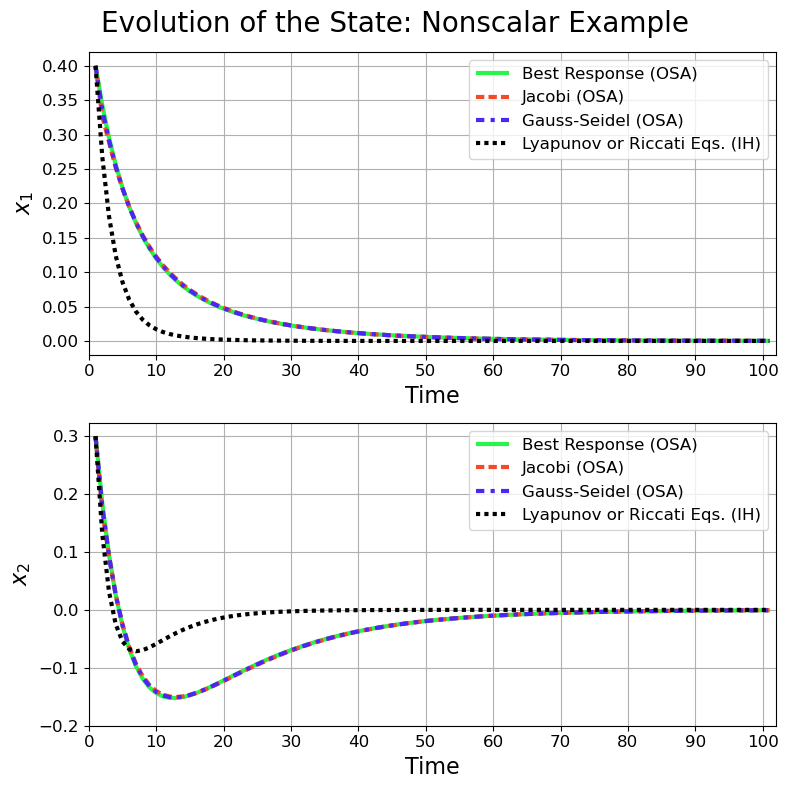

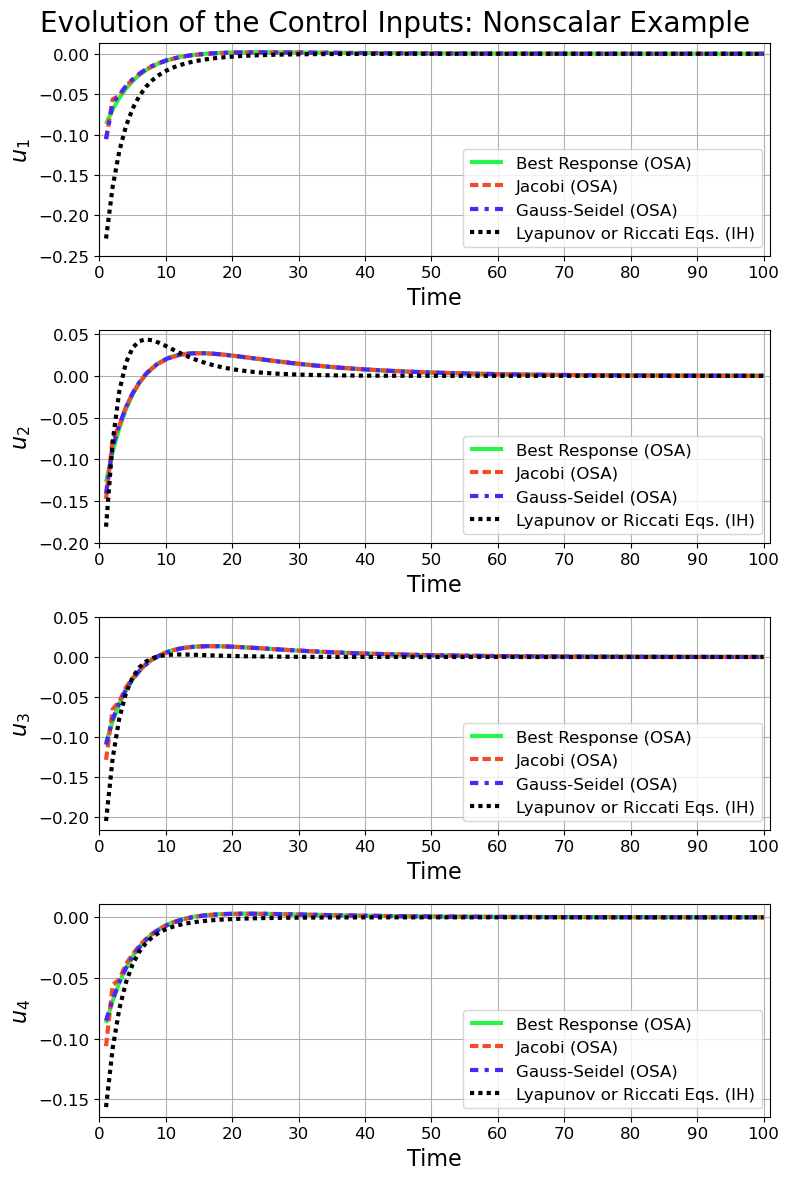

In [9]:
PyPlot.svg(true)

save_files = false #true - save all figures and data / false - do not save

t1 = Array(1:1:Kf+1)
t2 = Array(1:1:Kf)

figure(figsize=(8,8))
subplot(2,1,1)
grid()
plot(t1,x_br[1,:], linestyle = (0, ()), color="#27F549", linewidth=3)
plot(t1,x_jac[1,:], linestyle = (0, (2, 1)), color="#F54927", linewidth=3)
plot(t1,x_gs[1,:], linestyle = (0, (2, 1.5, 1, 1.5)), color="#4927F5", linewidth=3)
plot(t1,x_nort[1,:], linestyle = (0, (1, 1)), color="#000000", linewidth=3)
legend(["Best Response (OSA)", "Jacobi (OSA)", "Gauss-Seidel (OSA)", "Lyapunov or Riccati Eqs. (IH)"],loc="best", fontsize=12)
ylabel("\$x_1\$", fontsize=16)
xlabel("Time", fontsize=16)
xlim(0,Kf+2)
yticks(fontsize=12)
xticks(Array(0:10:Kf), fontsize=12)

subplot(2,1,2)
grid()
plot(t1,x_br[2,:], linestyle = (0, ()), color="#27F549", linewidth=3)
plot(t1,x_jac[2,:], linestyle = (0, (2, 1)), color="#F54927", linewidth=3)
plot(t1,x_gs[2,:], linestyle = (0, (2, 1.5, 1, 1.5)), color="#4927F5", linewidth=3)
plot(t1,x_nort[2,:], linestyle = (0, (1, 1)), color="#000000", linewidth=3)
legend(["Best Response (OSA)", "Jacobi (OSA)", "Gauss-Seidel (OSA)", "Lyapunov or Riccati Eqs. (IH)"],loc="best", fontsize=12)
ylabel("\$x_2\$", fontsize=16)
xlabel("Time", fontsize=16)
xlim(0,Kf+2)
yticks(Array(-0.2:0.1:0.3), fontsize=12)
xticks(Array(0:10:Kf), fontsize=12)

suptitle("Evolution of the State: Nonscalar Example",fontsize=20)
tight_layout()

if save_files
    savefig("nonscalar_ex_state.eps", bbox_inches="tight")
end


figure(figsize=(8,12))
subplot(4,1,1)
grid()
plot(t2,u_br[1,:], linestyle = (0, ()), color="#27F549", linewidth=3)
plot(t2,u_jac[1,:], linestyle = (0, (2, 1)), color="#F54927", linewidth=3)
plot(t2,u_gs[1,:], linestyle = (0, (2, 1.5, 1, 1.5)), color="#4927F5", linewidth=3)
plot(t2,u_nort[1,:], linestyle = (0, (1, 1)), color="#000000", linewidth=3)
legend(["Best Response (OSA)", "Jacobi (OSA)", "Gauss-Seidel (OSA)", "Lyapunov or Riccati Eqs. (IH)"],loc="best", fontsize=12)
ylabel("\$u_1\$", fontsize=16)
xlabel("Time", fontsize=16)
xlim(0,Kf+1)
yticks(Array(-0.25:0.05:0), fontsize=12)
xticks(Array(0:10:Kf), fontsize=12)

subplot(4,1,2)
grid()
plot(t2,u_br[2,:], linestyle = (0, ()), color="#27F549", linewidth=3)
plot(t2,u_jac[2,:], linestyle = (0, (2, 1)), color="#F54927", linewidth=3)
plot(t2,u_gs[2,:], linestyle = (0, (2, 1.5, 1, 1.5)), color="#4927F5", linewidth=3)
plot(t2,u_nort[2,:], linestyle = (0, (1, 1)), color="#000000", linewidth=3)
legend(["Best Response (OSA)", "Jacobi (OSA)", "Gauss-Seidel (OSA)", "Lyapunov or Riccati Eqs. (IH)"],loc="best", fontsize=12)
ylabel("\$u_2\$", fontsize=16)
xlabel("Time", fontsize=16)
xlim(0,Kf+1)
yticks(Array(-0.2:0.05:0.05), fontsize=12)
xticks(Array(0:10:Kf), fontsize=12)

subplot(4,1,3)
grid()
plot(t2,u_br[3,:], linestyle = (0, ()), color="#27F549", linewidth=3)
plot(t2,u_jac[3,:], linestyle = (0, (2, 1)), color="#F54927", linewidth=3)
plot(t2,u_gs[3,:], linestyle = (0, (2, 1.5, 1, 1.5)), color="#4927F5", linewidth=3)
plot(t2,u_nort[3,:], linestyle = (0, (1, 1)), color="#000000", linewidth=3)
legend(["Best Response (OSA)", "Jacobi (OSA)", "Gauss-Seidel (OSA)", "Lyapunov or Riccati Eqs. (IH)"],loc="best", fontsize=12)
ylabel("\$u_3\$", fontsize=16)
xlabel("Time", fontsize=16)
xlim(0,Kf+1)
yticks(Array(-0.2:0.05:0.05), fontsize=12)
xticks(Array(0:10:Kf), fontsize=12)

subplot(4,1,4)
grid()
plot(t2,u_br[4,:], linestyle = (0, ()), color="#27F549", linewidth=3)
plot(t2,u_jac[4,:], linestyle = (0, (2, 1)), color="#F54927", linewidth=3)
plot(t2,u_gs[4,:], linestyle = (0, (2, 1.5, 1, 1.5)), color="#4927F5", linewidth=3)
plot(t2,u_nort[4,:], linestyle = (0, (1, 1)), color="#000000", linewidth=3)
legend(["Best Response (OSA)", "Jacobi (OSA)", "Gauss-Seidel (OSA)", "Lyapunov or Riccati Eqs. (IH)"],loc="best", fontsize=12)
ylabel("\$u_4\$", fontsize=16)
xlabel("Time", fontsize=16)
xlim(0,Kf+1)
yticks(Array(-0.15:0.05:0), fontsize=12)
xticks(Array(0:10:Kf), fontsize=12)


suptitle("Evolution of the Control Inputs: Nonscalar Example",fontsize=20)
tight_layout()

if save_files
    savefig("nonscalar_ex_controls.eps", bbox_inches="tight")
end

# Deviation from Best Response

In [10]:
x1_mean = abs(mean(x_br[1,:]))
x2_mean = abs(mean(x_br[2,:]))

u1_mean = abs(mean(u_br[1,:]))
u2_mean = abs(mean(u_br[2,:]))
u3_mean = abs(mean(u_br[3,:]))
u4_mean = abs(mean(u_br[4,:]))

RMSE_x1_jac = sqrt((1/(Kf+1))*sum((x_jac[1,:] - x_br[1,:]).^2))
RMSE_x2_jac = sqrt((1/(Kf+1))*sum((x_jac[2,:] - x_br[2,:]).^2))

RMSE_u1_jac = sqrt((1/Kf)*sum((u_jac[1,:] - u_br[1,:]).^2))
RMSE_u2_jac = sqrt((1/Kf)*sum((u_jac[2,:] - u_br[2,:]).^2))
RMSE_u3_jac = sqrt((1/Kf)*sum((u_jac[3,:] - u_br[3,:]).^2))
RMSE_u4_jac = sqrt((1/Kf)*sum((u_jac[4,:] - u_br[4,:]).^2))

CV_x1_jac = RMSE_x1_jac/x1_mean
CV_x2_jac = RMSE_x2_jac/x2_mean

CV_u1_jac = RMSE_u1_jac/u1_mean
CV_u2_jac = RMSE_u2_jac/u2_mean
CV_u3_jac = RMSE_u3_jac/u3_mean
CV_u4_jac = RMSE_u4_jac/u4_mean

println("Jacobi Game:")
println("Deviation (State x₁) = ", round(CV_x1_jac, digits=4))
println("Deviation (State x₂) = ", round(CV_x2_jac, digits=4))
println("Deviation (Player 1) = ", round(CV_u1_jac, digits=4))
println("Deviation (Player 2) = ", round(CV_u2_jac, digits=4))
println("Deviation (Player 3) = ", round(CV_u3_jac, digits=4))
println("Deviation (Player 4) = ", round(CV_u4_jac, digits=4), "\n")

RMSE_x1_gs = sqrt((1/(Kf+1))*sum((x_gs[1,:] - x_br[1,:]).^2))
RMSE_x2_gs = sqrt((1/(Kf+1))*sum((x_gs[2,:] - x_br[2,:]).^2))

RMSE_u1_gs = sqrt((1/Kf)*sum((u_gs[1,:] - u_br[1,:]).^2))
RMSE_u2_gs = sqrt((1/Kf)*sum((u_gs[2,:] - u_br[2,:]).^2))
RMSE_u3_gs = sqrt((1/Kf)*sum((u_gs[3,:] - u_br[3,:]).^2))
RMSE_u4_gs = sqrt((1/Kf)*sum((u_gs[4,:] - u_br[4,:]).^2))

CV_x1_gs = RMSE_x1_gs/x1_mean
CV_x2_gs = RMSE_x2_gs/x2_mean

CV_u1_gs = RMSE_u1_gs/u1_mean
CV_u2_gs = RMSE_u2_gs/u2_mean
CV_u3_gs = RMSE_u3_gs/u3_mean
CV_u4_gs = RMSE_u4_gs/u4_mean

println("Gauss-Seidel Game:")
println("Deviation (State x₁) = ", round(CV_x1_gs, digits=4))
println("Deviation (State x₂) = ", round(CV_x2_gs, digits=4))
println("Deviation (Player 1) = ", round(CV_u1_gs, digits=4))
println("Deviation (Player 2) = ", round(CV_u2_gs, digits=4))
println("Deviation (Player 3) = ", round(CV_u3_gs, digits=4))
println("Deviation (Player 4) = ", round(CV_u4_gs, digits=4), "\n")

Jacobi Game:
Deviation (State x₁) = 0.0551
Deviation (State x₂) = 0.0536
Deviation (Player 1) = 0.6875
Deviation (Player 2) = 0.7204
Deviation (Player 3) = 24.36
Deviation (Player 4) = 0.8253

Gauss-Seidel Game:
Deviation (State x₁) = 0.0255
Deviation (State x₂) = 0.0257
Deviation (Player 1) = 0.6266
Deviation (Player 2) = 0.4388
Deviation (Player 3) = 3.6012
Deviation (Player 4) = 0.0908

